<div class="alert alert-info">
At the end of this notebook we will have a complete dataset of [text, summary] of the bible for text summarisation.
<br>    <br>
This notebook is split in three parts:  
    
#### 1) Scraping bible summaries from biblesummary.info
    
<ul>
    <li> following results are saved to txt file for further processing:
    <ul>
        <li> summaries for each of the 66 books
        <li> summaries for each chapter of each book, 1189 in total
    </ul>
</ul>
    
#### 2) Extracting text from bible.txt 

<ul>
    <li> following results are saved to txt file for further processing:
    <ul>
        <li> text for each of the 66 books
        <li> text for each chapter of each book, 1189 in total
    </ul>
</ul>
    
#### 3) Some statistics for the data

<div class="alert alert-info">
    
## 1) Scraping bible summaries    
    
    
The reader is encouraged to take a quick look at the website:
    
    https://biblesummary.info/genesis

In [148]:
import spacy
import en_core_web_sm
nlp = en_core_web_sm.load()
from os import listdir
from os.path import isfile, join
import string
from bs4 import BeautifulSoup

In [149]:
# Extract all 66 URLs for the summaries
# Each URL holds multiple summaries for that book of the bible

import requests
page = requests.get("https://biblesummary.info/2-kings")

html = str(page.content)

names = []
subpages = []
substring = '<li><a href="'
endsymbol = '</a></li>'
count = html.count(substring)

for c in range(count):
    start = html.index(substring)
    html = html[start:]
    end = html.index(endsymbol)
    snippet = html[13:end]
    html = html[end:]
    names.append(snippet)
names

for n in range(len(names)):
    subpages.append(names[n][:names[n].index('"')])
    names[n] = names[n][names[n].index('>')+1 :]

chapter_urls = []

for elem in subpages:
    chapter_urls.append('https://biblesummary.info'+elem)
    
len(chapter_urls    )

66

In [150]:
def extract_summaries_from_website(website):
    """
    Input: An URL
    
    Output: 
        chapters: a list of the chapter_numbers
        
        summaries: a list with the summaries as string
    """
    
    page = requests.get(website)    

    summaries = []
    chapters = []

    # count = count occurences of '<p class="tweet_content">'
    html = str(page.content)
    substring = '<p class="tweet_content">'
    endsymbol = '</p>'
    count = html.count(substring)

    for c in range(count):

        # start = position of '<p class="tweet_content">'
        start = html.index(substring)   # 4965

        # rest_text = html[start:]
        html = html[start:]

        # end = position of '</p>'
        end = html.index(endsymbol)

        # snippet = rest_text[:end]
        snippet = html[:end]

        # rest_text = rest_text[end:]
        html = html[end:]

        # snippet = soup.clean_html(snippet)



        snippet = BeautifulSoup(snippet, "lxml").text

        chapter = snippet[:snippet.index(':')].replace('\\r\\n','')
        summary = snippet[snippet.index(':')+2 :].replace('\\','')

        chapters.append(chapter)
        summaries.append(summary)
        
    return chapters, summaries


In [151]:
# Use the above defined function to save all summaries and chapter_numbers

summaries = []
chapter_abbreviations = []

for url in chapter_urls:
    abbr, summ = extract_summaries_from_website(url)
    chapter_abbreviations.append(abbr)    
    summaries.append(summ)   

In [152]:
len(summaries), len(summaries[0])

(66, 50)

In [153]:
len(chapter_abbreviations), len(chapter_abbreviations[0])

(66, 50)

In [154]:
# How many chapters do we have in total?
# 1189 is actuall correct, I checked it manually on biblesummary.info

c = 0
for n in range(len(summaries)):
    c += len(summaries[n])
    #print(len(summaries[n]))
c    

1189

In [160]:
len(summaries), len(summaries[0])

(66, 50)

In [155]:
# save each summary in the form of a pre-processed string

summaries = [[nlp(summary.replace('\n','')) for summary in elem] for elem in summaries]
summaries = [[[token.text.lower() for token in summary if ' ' not in token.text] for summary in elem] for elem in summaries]

with open('1189_test_summaries.txt', 'a') as the_file:
    for n in range(len(names)):
        for i in range(len(summaries[n])):
            the_file.write(' '.join(summaries[n][i]) + '\n')     
        

In [156]:
summaries_66 = [' '.join([' '.join(summary) for summary in book]) for book in summaries]

In [157]:
len(summaries_66), len(summaries_66[0]), len(summaries), len(summaries[0])

(66, 6805, 66, 50)

In [158]:
with open('66_test_summaries.txt', 'a') as the_file:
    for n in range(len(summaries_66)):
        the_file.write(summaries_66[n] + '\n')


In [ ]:
# achieved:

# bible_chapter_summaries is a file with all 1189 summaries

# bible_chapter_summaries_66 is a file with all 1189 summaries concatenated to be 66 e.g. one for each book

<div class="alert alert-info">
    
## 2) Extracting text from bible.txt


The bible.txt used below is the product of a former assignment of one of the team members' undergraduate studies. The raw data that were used back then are available at kaggle: <a href="https://www.kaggle.com/oswinrh/bible">https://www.kaggle.com/oswinrh/bible</a>. It is the same source that we use for creating our summaries and the goldstandard by extracting the first sentence. 

In [74]:
import spacy
import en_core_web_sm
nlp = en_core_web_sm.load()
from os import listdir
from os.path import isfile, join
import string
import re

In [75]:

#with open('/Users/nico/tf/bible.txt', 'r') as f:
with open('bible.txt', 'r') as f:
     bible = f.read()

In [76]:
# The following are landmarks that appear before each chapter, so they are useful landmarks to chunk the file into peaces, each one containing a chapter

substring = '\n\n\n\n\n'
endsymbol = '\n\n\n'
count = bible.count(substring)

In [77]:
# how many chapters do we have?
count

66

In [78]:
# This cell uses the above defined landmarks to to pick out substrings (e.g. books) from the text file and save them in the list 'books'

books = []
for i in range(count):
    if i == 0:
        substring = 'The First Book of Moses'
    else: 
        substring = '\n\n\n\n\n'
        

    start = bible.index(substring)
    substring = '\n\n\n\n\n'


    bible = bible[start+5:]
    if i < count-1:
        end = bible.index(substring)
    else:
        end = len(bible)

    snippet = bible[:end]
    bible = bible[end-5:]
    books.append(snippet)
    
books.pop(39)
books.append(books[-1][3690:])
books[-2] = books[-2][:3690]

So, what I have found is the positions of the beginnings of the books of the bible. 



In [79]:
# In every one of the 66 books, every sentence is numbered with 'chapter_number : sentence_number'. 
# The following is a lookup-function to search for those numerations. 
# They will be used to divide each book into multiple chapters.


def search_patterns(string):
    m1 = re.search(r"\d:\d", string)
    m2 = re.search(r"\d:\d\d", string)
    m3 = re.search(r"\d:\d\d\d", string)
    
    m4 = re.search(r"\d\d:\d", string)
    m5 = re.search(r"\d\d:\d\d", string)
    m6 = re.search(r"\d\d:\d\d\d", string)
    
    m7 = re.search(r"\d\d\d:\d", string)
    m8 = re.search(r"\d\d\d:\d\d", string)
    m9 = re.search(r"\d\d\d:\d\d\d", string)

    if m9 != None:
        return m9
    if m8 != None:
        return m8
    if m7 != None:
        return m7
    if m6 != None:
        return m6
    if m6 != None:
        return m5
    if m4 != None:
        return m4
    if m3 != None:
        return m3
    if m2 != None:
        return m2
    if m1 != None:
        return m1

In [80]:
# This function will be extract the sentences and chapter_numbers from each of the above
# defined books.

def extract_chapter_nums_and_sentences(book):
    """
    Input: One of the 66 bible_books as a string
    
    Output:
        chapters: a list with chapter_numbers for each sentence of the book
        sentences: a list with all the sentences of the book    
    """
    
    chap_nums = []
    sentences = []

    book = book.replace('\n',' ')

    finished = False
    while not finished:
        m = re.search(r"\d:\d", book)
        if m == None:
            finished = True
            break
        begin, end = m.span()
        m = search_patterns(book[ : end+1])

        chap_num = m[0]

        book = book[end+1 :]

        m2 = re.search(r"\d:\d", book)
        if m2 == None:
            sentence = book
            finished = True


        if m2 != None:
            begin2, end2 = m2.span()
            m = search_patterns(book[ : end2+1])
            begin2,end2 = m.span()
            sentence = book[ : begin2]


        chap_nums.append(chap_num)
        sentences.append(sentence)
        
        for i, chap in enumerate(chap_nums):
            m = re.search(r":", chap)
            begin, end = m.span()
            chap_nums[i] = chap[:end]
            chap_nums[i] = chap_nums[i]
            
    for i in range(len(chap_nums)):
        chap_nums[i] = chap_nums[i][:-1]
        
    # achieved: c, s
    

    c = chap_nums
    s = sentences
    
    cc = []
    ss = []
    
    chapter_text = ''

    for i in range(len(c)):
        if c[i] not in cc:
            cc.append(c[i])        
            if i != 0:
                ss.append(chapter_text.replace('   ',' ').replace('  ', ' '))
            chapter_text = s[i]

        if c[i] in cc:
            if s[i] != chapter_text:
                chapter_text += s[i]
            if i == len(c)-1:
                ss.append(chapter_text.replace('   ',' ').replace('  ', ' '))


    return cc, ss


In [83]:
# Use the above defined function to extract the chapters and senteces

chapters_1189 = []
sentences_1189 = []

for i, book in enumerate(books):
    c, s = extract_chapter_nums_and_sentences(book)
    chapters_1189.append(c)
    sentences_1189.append(s)

In [84]:
len(chapters_1189), len(sentences_1189), len(books)

(66, 66, 66)

In [85]:
len(chapters_1189[1]), len(sentences_1189[1])

(40, 40)

In [86]:
# How many chapters do we have?
# 1189 is actuall correct, I checked it manually on biblesummary.info
# len(sentences) == len(summaries) True
c = 0
for n in range(len(sentences_1189)):
    c += len(sentences_1189[n])
c

1189

In [87]:
# Apply some pre-processing before saving to txt.file

sentences_1189 = [[nlp(sentence.replace('\n','')) for sentence in elem] for elem in sentences_1189]

sentences_1189 = [[[token.text.lower() for token in sentence if ' ' not in token.text] for sentence in elem] for elem in sentences_1189]

In [94]:
# Save in txt file as 1189 chapters separated by new line

with open('1189_test_bible_chapters.txt', 'a') as the_file:
    for n in range(len(sentences_1189)):
        for i in range(len(sentences_1189[n])):
            the_file.write(' '.join(sentences_1189[n][i]) + '\n')                     

In [95]:
# calulate max length (in number of words) of the 1189 bible chapters

maxlen = 0
for n in range(len(sentences_1189)):
    for i in range(len(sentences_1189[n])):
        if len(sentences_1189[n][i]) > maxlen:
            maxlen = len(sentences_1189[n][i])
maxlen            

2907

In [96]:
# Concatenate all chapters back to books to have a file with 66 elements

sentences_66 = [' '.join([' '.join(summary) for summary in book]) for book in sentences_1189]

In [98]:
len(sentences_66), len(sentences_66[0])

(66, 203520)

In [99]:
with open('66_test_bible_chapters.txt', 'a') as the_file:
    for n in range(len(summaries_66)):
        the_file.write(summaries_66[n] + '\n')


<div class="alert alert-info">
    
## 3) Some statistics for the data

In [108]:
sum_text_ratio_66 = []
for n in range(len(summaries_66)):
    sum_text_ratio.append(len(summaries_66[n]) / len(sentences_66[n]))

In [137]:
sum_text_ratio_1189 = []
for n in range(len(summaries)):
    for i in range(len(summaries[n])):        
        sum_text_ratio_1189.append(len(' '.join(summaries[n][i])) / len(' '.join(sentences_1189[n][i])))


In [115]:
#sentences_1189[0][0]
#summaries[0][0]

['god',
 'created',
 'the',
 'heavens',
 ',',
 'the',
 'earth',
 'and',
 'everything',
 'that',
 'lives',
 '.',
 'he',
 'made',
 'humankind',
 'in',
 'his',
 'image',
 ',',
 'and',
 'gave',
 'them',
 'charge',
 'over',
 'the',
 'earth',
 '.']

In [113]:
#sentences_66[0]
#summaries_66[0]

'god created the heavens , the earth and everything that lives . he made humankind in his image , and gave them charge over the earth . god formed a man and gave him the garden in eden , except the tree of good and evil . adam was alone so god made a woman as his partner . the serpent deceived the woman . she and adam ate from the tree . the ground was cursed , and god sent adam and eve out of the garden . eve \'s sons made offerings to the lord . only abel \'s was acceptable , so cain killed him . abel \'s blood cried out and god sent cain away . adam \'s line was : seth , enosh , kenan , mahalalel , jared , enoch , methuselah , lamech and noah . noah \'s sons were shem , ham and japheth . humankind corrupted the earth with evil . god decided to destroy them . he told noah to build an ark to be saved from the flood . noah and his family went into the ark with two of each creature . it rained for forty days and forty nights and the earth was covered . the flood abated . noah sent out a

In [139]:
chapters_per_book = []
for n in range(len(summaries)):
    chapters_per_book.append(len(summaries[n]))

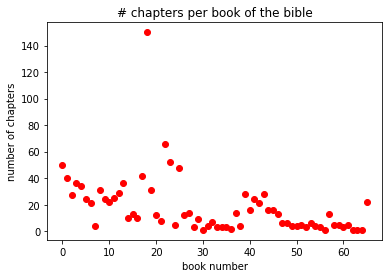

In [147]:
import matplotlib.pyplot as plt
plt.plot(chapters_per_book, 'ro')
plt.title('# chapters per book of the bible')
plt.ylabel('number of chapters')
plt.xlabel('book number')
#plt.ylim((0,0.1))
plt.show()

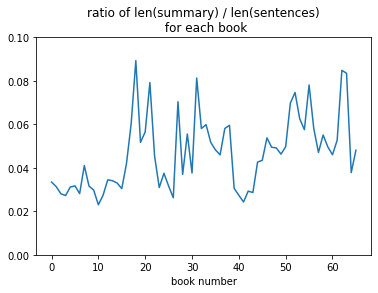

In [145]:
import matplotlib.pyplot as plt
plt.plot(sum_text_ratio)
plt.title('ratio of len(summary) / len(sentences)\n for each book')
#plt.ylabel('')
plt.xlabel('book number')
plt.ylim((0,0.1))
plt.show()

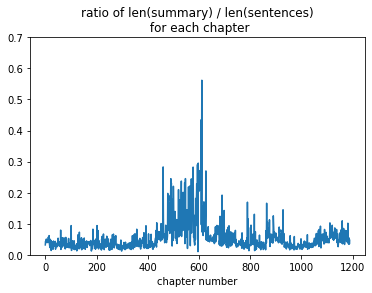

In [144]:
import matplotlib.pyplot as plt
plt.plot(sum_text_ratio_1189)
plt.title('ratio of len(summary) / len(sentences)\n for each chapter')
#plt.ylabel('')
plt.xlabel('chapter number')
plt.ylim((0,0.7))
plt.show()